## Random Forest Classifier

A Random Forest Classifier is the same as a Random Forest Regressor but changed for classification. It takes the mode, or most frequent prediction, from its decision trees.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.datasets import load_breast_cancer, fetch_kddcup99

In [ ]:
class Node:

    def __init__(self, left, right, gini_imp, feat, split, avg_class):
        self.left = left
        self.right = right
        self.gini_imp = gini_imp
        self.feat = feat
        self.split = split
        self.avg_class = avg_class


class DecisionTreeClassifer:

    def __init__(self, max_depth=3, min_samples_split=5, max_features=3):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.root = None
    
    def calc_gini_impurity(self, data, target_col):

        labels = data[target_col].unique()

        class_dist = [len(data[data[target_col] == lbl]) for lbl in labels]

        return 1 - sum([(cls_dist/len(data))**2 for cls_dist in class_dist])

    def fit(self, data, target_col):

        self.root = self._fit(data, target_col, float("inf"), 0)
    
    def _fit(self, data, target_col, parent_gini_imp, depth):

        if len(data) < self.min_samples_split or depth >= self.max_depth:

            print(f"Leaf node. Gini {parent_gini_imp}, Prediction {data[target_col].mode()[0]}")

            return Node(None, None, parent_gini_imp, None, None, data[target_col].mode()[0])

        features = [x for x in data.columns if x != target_col]
        features = np.random.choice(features, self.max_features, replace=False)

        best_feat, best_split = None, None
        best_gini_imp = parent_gini_imp

        for feat in features:

            uniques = sorted(data[feat].unique())

            for i in range(1, len(uniques)):

                split = (uniques[i] + uniques[i - 1]) / 2

                left_region = data[data[feat] < split]
                right_region = data[data[feat] >= split]

                total_gini_imp = (len(left_region)/len(data))*self.calc_gini_impurity(left_region, target_col) + (len(right_region)/len(data))*self.calc_gini_impurity(right_region, target_col)

                if total_gini_imp < best_gini_imp:
                    
                    best_feat, best_split = feat, split
                    best_gini_imp = total_gini_imp
        
        if not best_feat:

            print(f"Leaf node. Gini {parent_gini_imp}, Prediction {data[target_col].mode()[0]}")

            return Node(None, None, best_gini_imp, None, None, data[target_col].mode()[0])
        
        node = Node(None, None, best_gini_imp, best_feat, best_split, data[target_col].mode()[0])

        print(f"Node Gini imp {best_gini_imp}, Node best feat {best_feat}, Node best split {best_split}, Node avg class {data[target_col].mode()[0]}, Node depth {depth}")
        node.left = self._fit(data[data[best_feat] < best_split], target_col, best_gini_imp, depth+1)
        node.right = self._fit(data[data[best_feat] >= best_split], target_col, best_gini_imp, depth+1)
        return node

    def predict(self, data):

        return np.array([self._predict(obs[1]) for obs in data.iterrows()])

    def _predict(self, obs):

        if not self.root:

            print("Model not fitted")

            return

        curr = self.root

        while curr.left and curr.right:

            split, feat = curr.split, curr.feat

            if obs[feat] < split:

                curr = curr.left
            
            else:

                curr = curr.right
        return curr.avg_class
    
class RandomForestClassifier:

    def __init__(self, num_trees=3, max_depth=3, min_samples=5, max_features=3):

        self.num_trees = num_trees
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.max_features = max_features
        self.trees = {}
    
    def fit(self, data, target_col):

        for k in range(self.num_trees):

            temp_data = data.sample(n=len(data), replace=True)

            temp_data.reset_index(drop=True, inplace=True)

            dc = DecisionTreeClassifer(min_samples_split=self.min_samples, max_depth=self.max_depth, max_features=self.max_features)

            dc.fit(temp_data, target_col)

            tree_cols = [col for col in temp_data.columns if col != target_col]

            self.trees[f"decision_tree_{k+1}"] = {"Features": tree_cols, "Max Depth": self.max_depth,
                                                  "Min Samples Split": self.min_samples,
                                                    "Fitted Model": dc}
    
    def predict(self, data):

        predictions = []

        for dc in self.trees.values():
            
            tree = dc["Fitted Model"]

            pred = tree.predict(data)

            predictions.append(pred)

        output = []

        for i in range(len(data)):

            tree_preds = [tree[i] for tree in predictions]
            freq_dict = {label:tree_preds.count(label) for label in set(tree_preds)}

            sorted_lbls_by_count = sorted(freq_dict.keys(), key=lambda lbl: freq_dict[lbl], reverse=True)

            output.append(sorted_lbls_by_count[0])


        return np.array(output)
    
    def get_feature_importances(self):

        if not self.trees:

            print("Tree Not Fitted")

            return
        
        trees = [t["Fitted Model"] for t in self.trees.values()]

        data_columns = list(self.trees.values())[0]["Features"]

        return self._get_feature_importances(trees, data_columns)
    
    def _get_feature_importances(self, trees, cols):

        trees_feat_imps = []

        total_reduction = 0

        for tree in trees:

            feat_imp = {col:0 for col in cols}

            stack = [tree.root]

            while stack:

                parent = stack.pop()
                left_c, right_c = parent.left, parent.right

                if left_c and left_c.feat:
                    
                    stack.append(left_c)
                    feat_imp[left_c.feat] += parent.gini_imp - left_c.gini_imp
                
                if right_c and right_c.feat:

                    stack.append(right_c)
                    feat_imp[right_c.feat] += parent.gini_imp - right_c.gini_imp
                
            
            total_reduction += sum(list(feat_imp.values()))

            trees_feat_imps.append(feat_imp)

        
        avg_feat_imps = {}

        for col in cols:

            trees_col_imps = [tree_imp[col] for tree_imp in trees_feat_imps]

            avg_feat_imps[col] = (sum(trees_col_imps) / len(trees_col_imps)) * 1/total_reduction

        
        
        return pd.Series(index=list(avg_feat_imps.keys()), data=list(avg_feat_imps.values()), name="Feature Importances").sort_values(ascending=True)



In [25]:
def accuracy(y_true, y_hat):

    return sum(y_true == y_hat) / len(y_true)

In [26]:
np.random.seed(42)

breast = load_breast_cancer(as_frame=True)
target_col = "target"
data = pd.concat([breast["data"], breast[target_col]], axis=1)
data = data.sample(frac=1, replace=False)
data.reset_index(drop=True, inplace=True)
data


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,12.470,18.60,81.09,481.9,0.09965,0.10580,0.08005,0.03821,0.1925,0.06373,...,24.64,96.05,677.9,0.14260,0.23780,0.26710,0.10150,0.3014,0.08750,1
1,18.940,21.31,123.60,1130.0,0.09009,0.10290,0.10800,0.07951,0.1582,0.05461,...,26.58,165.90,1866.0,0.11930,0.23360,0.26870,0.17890,0.2551,0.06589,0
2,15.460,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,0.05796,...,26.00,124.90,1156.0,0.15460,0.23940,0.37910,0.15140,0.2837,0.08019,0
3,12.400,17.68,81.47,467.8,0.10540,0.13160,0.07741,0.02799,0.1811,0.07102,...,22.91,89.61,515.8,0.14500,0.26290,0.24030,0.07370,0.2556,0.09359,1
4,11.540,14.44,74.65,402.9,0.09984,0.11200,0.06737,0.02594,0.1818,0.06782,...,19.68,78.78,457.8,0.13450,0.21180,0.17970,0.06918,0.2329,0.08134,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,8.888,14.64,58.79,244.0,0.09783,0.15310,0.08606,0.02872,0.1902,0.08980,...,15.67,62.56,284.4,0.12070,0.24360,0.14340,0.04786,0.2254,0.10840,1
565,11.640,18.33,75.17,412.5,0.11420,0.10170,0.07070,0.03485,0.1801,0.06520,...,29.26,85.51,521.7,0.16880,0.26600,0.28730,0.12180,0.2806,0.09097,1
566,14.290,16.82,90.30,632.6,0.06429,0.02675,0.00725,0.00625,0.1508,0.05376,...,20.65,94.44,684.6,0.08567,0.05036,0.03866,0.03333,0.2458,0.06120,1
567,13.980,19.62,91.12,599.5,0.10600,0.11330,0.11260,0.06463,0.1669,0.06544,...,30.80,113.90,869.3,0.16130,0.35680,0.40690,0.18270,0.3179,0.10550,0


In [27]:
train_size = 0.8
train_data = data[:int(len(data)*train_size)]
test_data = data[int(len(data)*train_size):]

print("Train Data Shape: ",train_data.shape)
print("Test Data Shape: ",test_data.shape)

Train Data Shape:  (455, 31)
Test Data Shape:  (114, 31)


In [28]:
num_trees=20
max_depth=5
min_samples=5
max_features=3

my_rfc = RandomForestClassifier(max_depth=max_depth, max_features=max_features, num_trees=num_trees, min_samples=min_samples)
sklearn_rfc = RFC(max_depth=max_depth, max_features=max_features, min_samples_split=min_samples, n_estimators=num_trees)

my_rfc.fit(train_data, target_col)
sklearn_rfc.fit(train_data.drop(columns=[target_col]), train_data[target_col])

Node Gini imp 0.33737724292534677, Node best feat worst compactness, Node best split 0.25325, Node avg class 1, Node depth 0
Node Gini imp 0.0968542092260717, Node best feat area error, Node best split 37.42, Node avg class 1, Node depth 1
Node Gini imp 0.027016742770167246, Node best feat smoothness error, Node best split 0.0029975, Node avg class 1, Node depth 2
Leaf node. Gini 0.027016742770167246, Prediction 0
Node Gini imp 0.018346253229974026, Node best feat mean concavity, Node best split 0.11889999999999999, Node avg class 1, Node depth 3
Node Gini imp 0.017718715393134004, Node best feat smoothness error, Node best split 0.004703000000000001, Node avg class 1, Node depth 4
Leaf node. Gini 0.017718715393134004, Prediction 1
Leaf node. Gini 0.017718715393134004, Prediction 1
Leaf node. Gini 0.018346253229974026, Prediction 0
Leaf node. Gini 0.0968542092260717, Prediction 0
Node Gini imp 0.15312178300809481, Node best feat worst concave points, Node best split 0.14415, Node avg c

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",20
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",3
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_true, 

In [29]:
my_rfc_acc = accuracy(test_data[target_col], my_rfc.predict(test_data))
sklearn_rfc_acc = accuracy(test_data[target_col], sklearn_rfc.predict(test_data.drop(columns=[target_col])))

pd.DataFrame({"Accuracy": [my_rfc_acc, sklearn_rfc_acc]}, index=["My RFC", "Sklearn RFC"])

,Accuracy
My RFC,0.929825
Sklearn RFC,0.956140


<Axes: title={'center': 'Feature Importances'}>

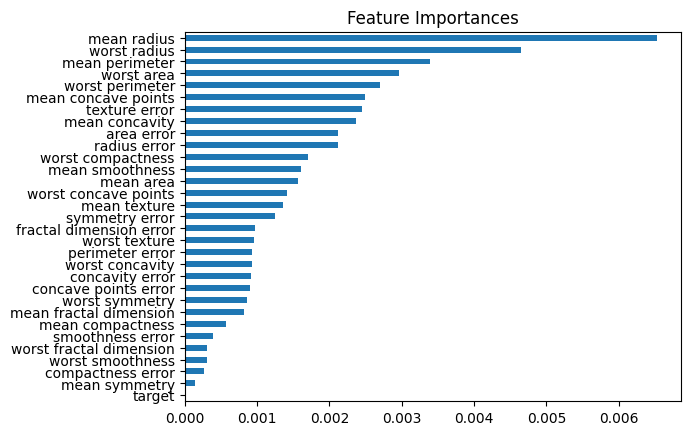

In [30]:
feat_imp = my_rfc.get_feature_importances()
feat_imp.plot(kind="barh", title="Feature Importances")

<Axes: title={'center': 'Sklearn Feature Importances'}>

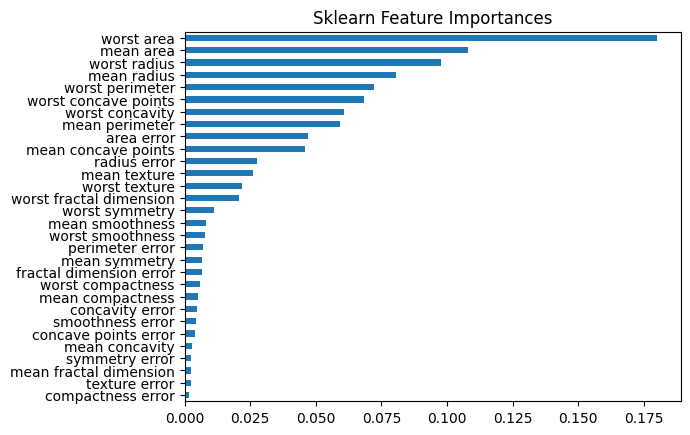

In [31]:
pd.Series(index=sklearn_rfc.feature_names_in_, data=sklearn_rfc.feature_importances_).\
sort_values(ascending=True).\
plot(kind="barh", title="Sklearn Feature Importances")